In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/swiftai")' SwiftAI

Installing packages:
	.package(path: "/home/mlk/swift/swiftai")
		SwiftAI
With SwiftPM flags: []
Working in: /tmp/tmprlcxrsq2/swift-install
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swiftc: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swiftc)
/home/mlk/swift/usr/bin/swiftc: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no v

In [2]:
import SwiftAI
import TensorFlow
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")

In [3]:
import Foundation
import Just
import Path

In [4]:
let d = mnistDataBunch(path: Path.home/"swift", flat: true, bs: 256)

2019-11-25 11:46:18.758873: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 188160000 exceeds 10% of system memory.
2019-11-25 11:46:18.859044: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2019-11-25 11:46:18.921437: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-11-25 11:46:18.926747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-11-25 11:46:18.927068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 970 major: 5 minor: 2 memoryClockRate(GHz): 1.253
pciBusID: 0000:01:00.0
2019-11-25 11:46:18.960570: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened

In [5]:
d.train.ds.first(where: { _ in true })!.xb.shape

▿ [256, 784]
  ▿ dimensions : 2 elements
    - 0 : 256
    - 1 : 784


In [6]:
//MLP model with 2 hidden layers
public struct MyModel: Layer {
    public var hidden1: FADense<Float>
    public var hidden2: FADense<Float>
    public var out:     FADense<Float>
    
    public init(nIn: Int, nHid: Int, nOut: Int){
        hidden1 = FADense(nIn, nHid, activation: relu)
        hidden2 = FADense(nHid, nHid, activation: relu)
        out =     FADense(nHid, nOut)
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        return out(hidden2(hidden1(input)))
    }
}


In [7]:
func modelInit() -> MyModel { return MyModel(nIn: 784,nHid: 512, nOut: 10) }

In [8]:
// Source: http://cs231n.github.io/neural-networks-3/#sgd

public extension StateKeys {
    static let prevGrad = "previousAverageGrad"
}

public struct PreviousAverageGrad: StatDelegate {
    public var defaultHPs: [String:Float] { return [:] }
    public var name: String { return StateKeys.prevGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.prevGrad]! = state[StateKeys.avgGrad]!
    }
}

public struct AvgGrad: StatDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9] }
    public let dampened: Bool
    public init(dampened: Bool = false) { self.dampened = dampened }
    public var name: String { return StateKeys.avgGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.avgGrad]! *= hps[HyperParams.mom]!
        hps[HyperParams.momDamp] = 1.0 - (dampened ? hps[HyperParams.mom]! : 0.0)
        state[StateKeys.avgGrad]! -= hps[HyperParams.lr]! * 𝛁p
    }
}

public struct NesterovStep: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9]}
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, 
                       state: [String : TF], 
                       hps: inout [String : Float]){
        p += -hps[HyperParams.mom]! * state[StateKeys.prevGrad]! + ( 1 + hps[HyperParams.mom]!) * state[StateKeys.avgGrad]!
    }
}


In [9]:
public struct L1: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        𝛁p += hps[HyperParams.wd]! * abs(p).sum()
    }
}

public struct L2: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        𝛁p += hps[HyperParams.wd]! * p
    }
}

# MLP 1 with SGD

In [10]:
func sgd(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [SGDStep()], 
                             stats: [], 
                             hps: [HyperParams.lr: 0.01])
}

let learner_sgd = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: sgd, 
                    modelInit: modelInit)

let recorder_sgd = learner_sgd.makeDefaultDelegates(metrics: [accuracy])
learner_sgd.addDelegates([learner_sgd.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)])

In [12]:
try! learner_sgd.fit(25)

2019-11-25 11:47:00.588825: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
Epoch 0: [0.41809213, 0.8922]                                                  
Epoch 1: [0.31533402, 0.9125]                                                  
Epoch 2: [0.273459, 0.9223]                                                    
Epoch 3: [0.24868932, 0.9311]                                                  
Epoch 4: [0.2282586, 0.9355]                                                   
Epoch 5: [0.21250889, 0.9406]                                                  
Epoch 6: [0.20093067, 0.9418]                                                  
Epoch 7: [0.19147848, 0.9445]                                                  
Epoch 8: [0.1815941, 0.9478]                                                   
Epoch 9: [0.17328143, 0.9499]                                                  
Epoch 10: [0.16647558, 0.9524]                        

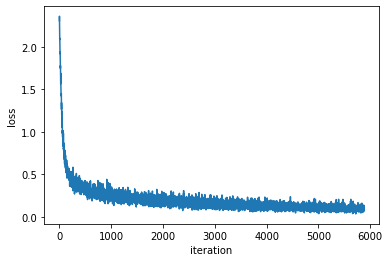

In [14]:
recorder_sgd.plotLosses()

# MLP 2 with  Nesterov

In [15]:
func sgdnest_opt(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep()], 
                             stats: [PreviousAverageGrad(),AvgGrad()], 
                             hps: [HyperParams.lr: 0.01])
}

let learner_nest = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: sgdnest_opt, 
                    modelInit: modelInit)

let recorder_nest = learner_nest.makeDefaultDelegates(metrics: [accuracy])
learner_nest.addDelegates([learner_nest.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)])

In [16]:
try! learner_nest.fit(25)

Epoch 0: [0.18616255, 0.946]                                                   
Epoch 1: [0.13291715, 0.9599]                                                  
Epoch 2: [0.10699914, 0.9661]                                                   
Epoch 3: [0.093147054, 0.9704]                                                 
Epoch 4: [0.0825852, 0.9734]                                                   
Epoch 5: [0.079482324, 0.9753]                                                 
Epoch 6: [0.07580322, 0.9755]                                                  
Epoch 7: [0.07115934, 0.9766]                                                  
Epoch 8: [0.067816615, 0.9787]                                                 
Epoch 9: [0.06913602, 0.9785]                                                  
Epoch 10: [0.06747065, 0.9786]                                                 
Epoch 11: [0.064500466, 0.9799]                                                
Epoch 12: [0.06414337, 0.9795]         

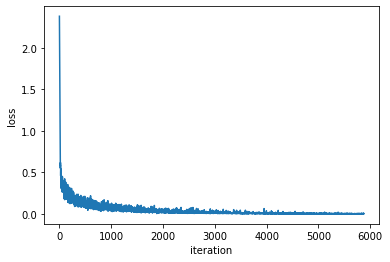

In [17]:
recorder_nest.plotLosses()

# MLP 3 with Nesterov and L1

In [18]:
//Optimizer with Nesterov step and L1 regularizer
func optFunc(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep(), L1()], 
                             stats: [PreviousAverageGrad(),AvgGrad()], 
                             hps: [HyperParams.lr: 0.01])
}

let learner_nest_l1 = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: optFunc, 
                    modelInit: modelInit)

let recorder_nest_l1 = learner_nest_l1.makeDefaultDelegates(metrics: [accuracy])
learner_nest_l1.addDelegates([learner_nest_l1.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)])

In [19]:
learner_nest_l1.fit(25)

Epoch 0: [0.18513611, 0.9456]                                                  
Epoch 1: [0.13154909, 0.9584]                                                  
Epoch 2: [0.10876113, 0.9677]                                                  
Epoch 3: [0.08965957, 0.973]                                                    
Epoch 4: [0.08286301, 0.9759]                                                  
Epoch 5: [0.07550116, 0.9774]                                                  
Epoch 6: [0.073035024, 0.977]                                                  
Epoch 7: [0.06905564, 0.979]                                                    
Epoch 8: [0.06637703, 0.9782]                                                  
Epoch 9: [0.06363194, 0.9787]                                                  
Epoch 10: [0.06579249, 0.9797]                                                 
Epoch 11: [0.06474247, 0.9788]                                                 
Epoch 12: [0.063263156, 0.9805]       

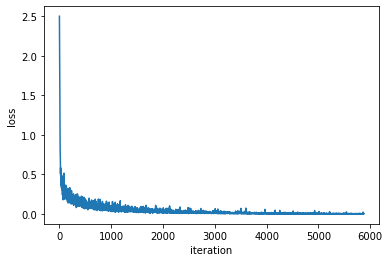

In [20]:
recorder_nest_l1.plotLosses()

# MLP 4 with Nesterov and L2

In [21]:
func SGD_nest_L2(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep(), L2()], 
                             stats: [PreviousAverageGrad(),AvgGrad()], 
                             hps: [HyperParams.lr: 0.01])
}

let learner_nest_l2 = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: SGD_nest_L2, 
                    modelInit: modelInit)

let recorder_nest_l2 = learner_nest_l2.makeDefaultDelegates(metrics: [accuracy])
learner_nest_l2.addDelegates([learner_nest_l2.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)])

In [22]:
learner_nest_l2.fit(25)

Epoch 0: [0.1840556, 0.9474]                                                   
Epoch 1: [0.14003219, 0.9578]                                                   
Epoch 2: [0.10877262, 0.9673]                                                  
Epoch 3: [0.09227904, 0.9721]                                                  
Epoch 4: [0.08674959, 0.9751]                                                  
Epoch 5: [0.078174286, 0.9766]                                                  
Epoch 6: [0.07648895, 0.9757]                                                  
Epoch 7: [0.0723128, 0.977]                                                    
Epoch 8: [0.067047946, 0.98]                                                   
Epoch 9: [0.064890616, 0.9792]                                                 
Epoch 10: [0.06279896, 0.9799]                                                 
Epoch 11: [0.062465306, 0.9803]                                                
Epoch 12: [0.06255239, 0.9811]        

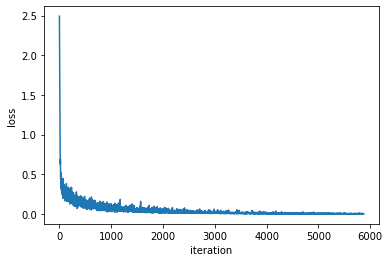

In [23]:
recorder_nest_l2.plotLosses()

In [24]:
let y = Array(0..<recorder_nest_l2.losses.count)
let sgd: Array<Float>     = recorder_sgd.losses.compactMap{$0.scalar}
let nest: Array<Float>    = recorder_nest.losses.compactMap{$0.scalar}
let nest_l1: Array<Float> = recorder_nest_l1.losses.compactMap{$0.scalar}
let nest_l2: Array<Float> = recorder_nest_l2.losses.compactMap{$0.scalar}


In [28]:
func smooth_curve(points:Array<Float>, factor:Float=0.9) -> Array<Float> {
    var smoothed_points: Array<Float> = Array()
    let x1 = points.first
    smoothed_points.append(x1!)
    var points_ = points.dropFirst()
    for point in points_{
            let previous = smoothed_points.last
            let smth = previous! * factor + point * (1 - factor)
            smoothed_points.append(smth)
    }
        
    return smoothed_points
}
    

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

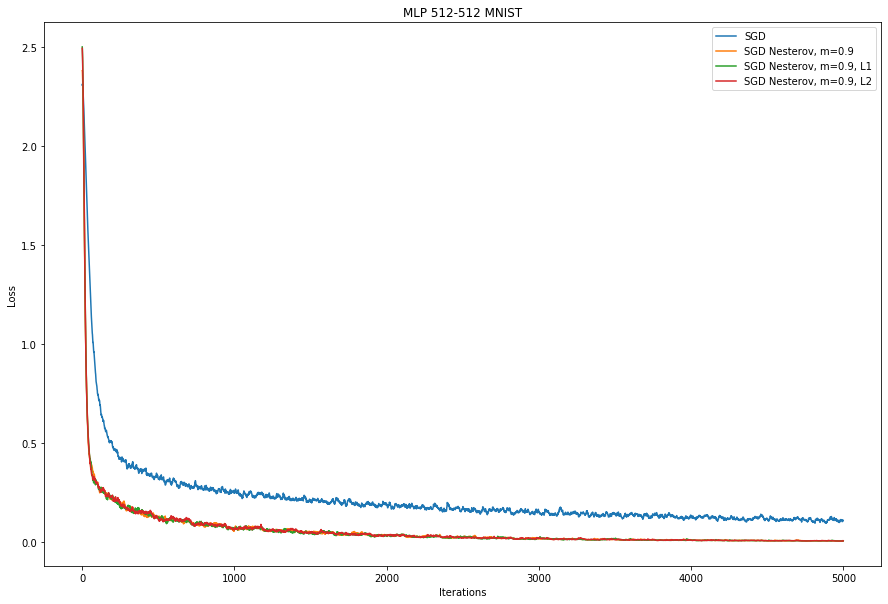

None


In [33]:
plt.figure(figsize: [15, 10])
let i = 0
let n = 5000
let y2 = Array(y[i..<n])
plt.plot(y2,smooth_curve(points: Array(sgd[i..<n])), label:"SGD")
plt.plot(y2,smooth_curve(points: Array(nest[i..<n])), label:"SGD Nesterov, m=0.9")
plt.plot(y2,smooth_curve(points: Array(nest_l1[i..<n])), label:"SGD Nesterov, m=0.9, L1")
plt.plot(y2,smooth_curve(points: Array(nest_l2[i..<n])), label:"SGD Nesterov, m=0.9, L2")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MLP 512-512 MNIST")
plt.show()